In [82]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn
from scipy.stats import hypergeom
import warnings
import scipy
warnings.filterwarnings('ignore')
import pickle
import scrublet as scr
import harmonypy as hm
import sys
from random import sample
from _util_updated import cluster_bias

### Load Data

In [52]:
#SC_DF = sc.read_h5ad('./DAP3_SC_072821.h5ad')

In [53]:
PATH = '../../Data/Pickles/'
Dict_File = open(PATH + "ALL_Large_sgRNA_Dic_Filtered.pkl", "rb")
SGRNA_CELLS_DIC = pickle.load(Dict_File)

In [55]:
PATH = '../../Data/Pickles/'
Dict_File = open(PATH + "Guide_Dictionary_Filtered.pkl", "rb")
Guide_Dictionary = pickle.load(Dict_File)

In [56]:
Clean_NC_Cells = []
[Clean_NC_Cells.extend(SGRNA_CELLS_DIC[i]) for i in Guide_Dictionary['NC']]

[None, None, None, None]

### Promoter Enhancer Dicts

In [58]:
### Enhancer Dic (Do firt. Not all promoters have enhancers)

Target_Name = []
Enhancer_Name = []
for target in Guide_Dictionary.keys():
    try:
        if target.split('_')[1].startswith('ENH'):
            Target_Name.append(target.split('_')[0])
            Enhancer_Name.append(target)
    except:
        continue
        
Enhancer_Set = []
for target in np.unique(Target_Name):
    Target_Set = []
    for target_enh in Enhancer_Name:
        if target_enh.split('_')[0] == target:
            Target_Set.append(target_enh)
    Enhancer_Set.append(Target_Set)
    
ENH_DICT = dict(zip(np.unique(Target_Name), Enhancer_Set))

### Add Missing TBX5 Set from Sean

ENH_DICT['TBX5'] = ['TBXEnh1']
ENH_DICT['TBX5'].append('TBXEnh2')
ENH_DICT['TBX5'].append('TBXEnh3')
ENH_DICT['TBX5'].append('TBXEnh4')
ENH_DICT['TBX5'].append('TBXEnh5')
ENH_DICT['TBX5'].append('TBXEnh6')

In [59]:
### Promoter Dic

Target_Name = []
Promoter_Name = []
for target in Guide_Dictionary.keys():
    try:
        if target.split('_')[0] not in ENH_DICT.keys():
            continue
        if target.split('_')[1].startswith('PROM'):
            Target_Name.append(target.split('_')[0])
            Promoter_Name.append(target)
    except:
        continue
        
Prom_Set = []
for target in np.unique(Target_Name):
    Target_Set = []
    for target_prom in Promoter_Name:
        if target_prom.split('_')[0] == target:
            Target_Set.append(target_prom)
    Prom_Set.append(Target_Set)
    
PROM_DICT = dict(zip(np.unique(Target_Name), Prom_Set))

### Add Missing TBX5 Set from Sean
PROM_DICT['TBX5'].append('TBX5_P1')
PROM_DICT['TBX5'].append('TBX5_P2')
PROM_DICT['TBX5'].append('TBX5_AS1_P1')
PROM_DICT['TBX5'].append('TBX5_AS1_P2')

In [62]:
tran_matrix = SC_DF
t_dict = Guide_Dictionary
s_dict = SGRNA_CELLS_DIC

dep_target_values = []
enr_target_values = []
Target_List = []
for target in Guide_Dictionary.keys():
    control_list = Clean_NC_Cells
    if target  == 'NC':
        for nc in Guide_Dictionary[target]:
            Target_List.append(nc)
            CELL_LIST = s_dict[nc]
            nc_controls = []
            for cell in Clean_NC_Cells:
                if cell not in CELL_LIST:
                    nc_controls.append(cell)
            dep_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = nc_controls, t_matrix=tran_matrix, direction = 'depletion')
            enr_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = nc_controls, t_matrix=tran_matrix, direction = 'enrichment')

            dep_target_values.append(dep_clust_values)
            enr_target_values.append(enr_clust_values)
    elif target == 'MALAT1':
        Target_List.append(target)
        CELL_LIST = s_dict[target]
        dep_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = control_list, t_matrix=tran_matrix, direction = 'depletion')
        enr_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = control_list, t_matrix=tran_matrix, direction = 'enrichment') 
        dep_target_values.append(dep_clust_values)
        enr_target_values.append(enr_clust_values)
    else:
        Target_List.append(target)
        guide_set = t_dict[target]
        CELL_LIST = []
        [CELL_LIST.extend(s_dict[Target_key]) for Target_key in list(guide_set)]
        dep_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = control_list, t_matrix=tran_matrix, direction = 'depletion')
        enr_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = control_list, t_matrix=tran_matrix, direction = 'enrichment') 
        dep_target_values.append(dep_clust_values)
        enr_target_values.append(enr_clust_values)
        
CM_filtered_dep_CM = pd.DataFrame(data = dep_target_values, columns  = tran_matrix.obs.louvain.cat.categories.tolist(), index= Target_List)  
CM_filtered_enr_CM = pd.DataFrame(data = enr_target_values, columns  = tran_matrix.obs.louvain.cat.categories.tolist(), index= Target_List)  

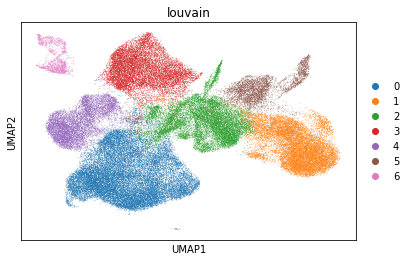

In [25]:
sc.pl.umap(SC_DF, color = 'louvain')

# TBX5 Percents

In [70]:
%%capture

cluster_order = ['1', '2', '5', '0', '4', '3', '6']

target = 'TBX5_PROM1'
Target_Cells = []
[Target_Cells.extend(SGRNA_CELLS_DIC[i]) for i in Guide_Dictionary[target]]
Target_DF = SC_DF[Target_Cells]

Target_Percents = []
for clust in cluster_order:
    Target_Percents.append((Target_DF[Target_DF.obs.louvain == clust].shape[0]/Target_DF.shape[0])*100)

NC_Percents = []
NC_DF = SC_DF[Clean_NC_Cells]
for clust in cluster_order:
    NC_Percents.append((NC_DF[NC_DF.obs.louvain == clust].shape[0]/NC_DF.shape[0])*100)

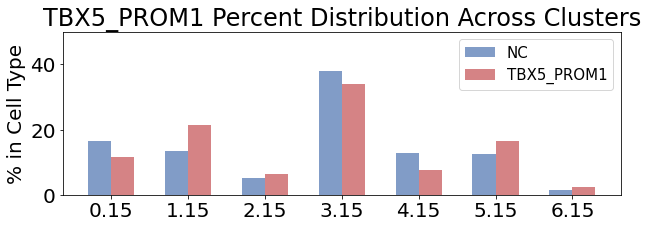

In [71]:
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(10,3))

#labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7']

N=7
ind = np.arange(N)

width = 0.3       # the width of the bars: can also be len(x) sequence

ax.bar(ind, NC_Percents, width, alpha = 0.7, label='NC', color = '#4c72b0')
ax.bar(ind+width, Target_Percents, width,  alpha = 0.7,
       label=target, color ='#c44e52')

ax.set_ylabel('% in Cell Type')
ax.set_title(target +  ' Percent Distribution Across Clusters')
plt.xticks(ind + width*.5)
plt.ylim(0,50)
ax.legend()
plt.legend(prop={'size': 15})
plt.savefig('./All_Cluster_Percentage_TBX5_PROM1.pdf')
plt.show()

### Expression ViolinPlot

In [73]:
TBX5_ENH_Cells = []
[TBX5_ENH_Cells.extend(SGRNA_CELLS_DIC[i]) for i in Guide_Dictionary['TBXEnh6']]

TBX5_PROM_Cells = []
[TBX5_PROM_Cells.extend(SGRNA_CELLS_DIC[i]) for i in Guide_Dictionary['TBX5_PROM1']]

[None, None, None, None, None, None, None]

In [74]:
Target_SG = []
for cell in SC_DF.obs.index:
    if cell in Clean_NC_Cells:
        Target_SG.append('NC')
    elif cell in TBX5_PROM_Cells and cell not in TBX5_ENH_Cells:
        Target_SG.append('TBX5_Prom1')
    elif cell in TBX5_ENH_Cells and cell not in TBX5_PROM_Cells:
        Target_SG.append('TBX5_Enh6')
    else:
        Target_SG.append('Other')
SC_DF.obs['SG'] = Target_SG
SC_DF_Subset = SC_DF[SC_DF.obs['SG'] != 'Other']

In [75]:
SC_DF_Subset = SC_DF_Subset[SC_DF_Subset.obs.louvain == '1']

In [76]:
Gene = 'NPPA'
Gene_Pos = np.argwhere(SC_DF_Subset.raw.var_names == Gene)[0][0]
TBX5_Prom1_Cells = SC_DF_Subset[SC_DF_Subset.obs.SG == 'TBX5_Prom1']
TBX5_Enh6_Cells = SC_DF_Subset[SC_DF_Subset.obs.SG == 'TBX5_Enh6']
NC_Cells = SC_DF_Subset[SC_DF_Subset.obs.SG == 'NC']

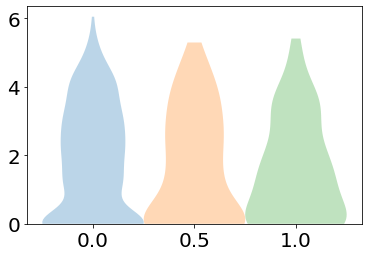

In [30]:
plt.violinplot(NC_Cells.raw.X[:,Gene_Pos].todense().tolist()/np.log(2), positions=[0], showextrema=False)
plt.violinplot(TBX5_Prom1_Cells.raw.X[:,Gene_Pos].todense().tolist()/np.log(2), positions=[.5], showextrema=False)
plt.violinplot(TBX5_Enh6_Cells.raw.X[:,Gene_Pos].todense().tolist()/np.log(2), positions=[1], showextrema=False)


plt.ylim(0)
plt.savefig('./All_Violin_' + Gene + '.pdf')

### Statistics (NPPA)

In [79]:
%%capture
CM_Control = SC_DF_Subset[SC_DF_Subset.obs.SG == 'NC']
Con_Mean = CM_Control.raw.X[:,Gene_Pos]/np.log(2)
Con_Means = []
[Con_Means.append(i[0]) for i in Con_Mean.mean(axis=1).tolist()]

CM_Perturb = SC_DF_Subset[SC_DF_Subset.obs.SG == 'TBX5_Prom1']
Perturb_Mean = CM_Perturb.raw.X[:,Gene_Pos]/np.log(2)
Perturb_Prom = []
[Perturb_Prom.append(i[0]) for i in Perturb_Mean.mean(axis=1).tolist()]

CM_Perturb = SC_DF_Subset[SC_DF_Subset.obs.SG == 'TBX5_Enh6']
Perturb_Mean = CM_Perturb.raw.X[:,Gene_Pos]/np.log(2)
Perturb_Enh = []
[Perturb_Enh.append(i[0]) for i in Perturb_Mean.mean(axis=1).tolist()]

In [80]:
print('p-val = ' + str(scipy.stats.mannwhitneyu(Perturb_Enh, Con_Means)[1]))

p-val = 0.03401136791144638
